## Analyze A/B Test Results for an e_commerce website


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working on the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [27]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset 

In [28]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [29]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [30]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [31]:
df[df['converted']==1].shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [32]:
(df[(df['group']=='control')&(df['landing_page']!='old_page')].shape[0])+(df[(df['group'] == 'treatment') & (df['landing_page']!='new_page')].shape[0])

3893

f. Check if there are any missing values

In [33]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. So I will be creating a new dataset that meets the specifications from the quiz.  Store my new dataframe in **df2**.

In [34]:
df_treatment = df[(df['group']=='treatment') & (df['landing_page']=='new_page')]
df_control = df[(df['group'] == 'control') & (df['landing_page'] == 'old_page')]
df2 = df_treatment.append(df_control)
df2

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
...,...,...,...,...,...
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0


In [35]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [36]:
df2.shape[0]

290585

`3.` 

a.  Unique **user_id**s are in **df2**

In [37]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.

In [38]:
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. Row information for the repeat **user_id**

In [39]:
df2[df2.duplicated(['user_id'],keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep my dataframe as **df2**.

In [40]:
df2 = df2.drop_duplicates(['user_id'],keep = 'first')

`4.` 

a. The probability of an individual converting regardless of the page they receive

In [41]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, the probability they converted

In [42]:
df_control = df2[df2['group']=='control']
df_control.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, the probability they converted

In [85]:
df_treatment = df2[df2['group']=='treatment']
df_treatment.converted.mean()

0.11880806551510564

d. The probability that an individual received the new page

In [44]:
(df2[df2['landing_page']=='new_page'].shape[0])/df2.shape[0]

0.5000619442226688

e. Consider my results from a. through d. above, the conversion rate for the control group is higher than that of the treatment group.However, the difference is only 0.158%. Since the probability is almost 50% , it is very unlikely that the difference in conversion rate is due to the probability of receiving new page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now,  we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.


H0: The conversion rate of the old page is larger or the same with that of the new page   
H1: The conversion rate of the old page is smaller than that of the old page

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will be performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. The **convert rate** for $p_{new}$ under the null

In [45]:
P_new = df2.converted.mean()
P_new

0.11959708724499628

b. The **convert rate** for $p_{old}$ under the null 

In [46]:
P_old = df2.converted.mean()
P_old

0.11959708724499628

c.  $n_{new}$

In [47]:
n_new = df2[df2['landing_page']=='new_page'].shape[0]
n_new

145310

d. $n_{old}$

In [48]:
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [52]:
new_page_converted = np.random.binomial(n_new,P_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [53]:
old_page_converted = np.random.binomial(n_old,P_old)

g. $p_{new}$ - $p_{old}$ for my simulated values from part (e) and (f).

In [54]:
new_page_converted/n_new - old_page_converted/n_old

-0.00030503740891014985

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one I calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [55]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,P_new)
    old_page_converted = np.random.binomial(n_old,P_old)
    p_diffs.append(new_page_converted/n_new - old_page_converted/n_old)  

i. Plot a histogram of the **p_diffs**.

(array([2.000e+00, 3.800e+01, 2.100e+02, 1.072e+03, 2.317e+03, 3.005e+03,
        2.238e+03, 8.910e+02, 1.960e+02, 3.100e+01]),
 array([-0.00512962, -0.00418738, -0.00324514, -0.00230289, -0.00136065,
        -0.00041841,  0.00052383,  0.00146607,  0.00240831,  0.00335055,
         0.00429279]),
 <a list of 10 Patch objects>)

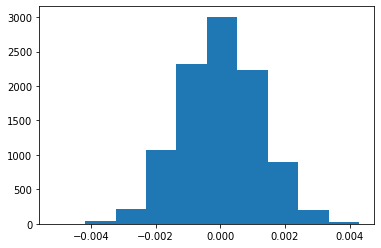

In [56]:
plt.hist(p_diffs)

j. The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [58]:
actual_diffs = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()

In [59]:
# P value
(np.array(p_diffs) > np.array(actual_diffs)).mean()

0.9057

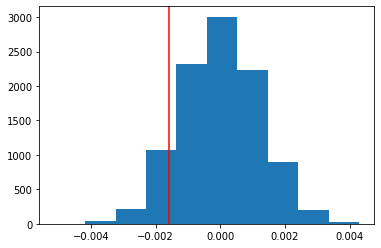

In [60]:
plt.hist(p_diffs)
plt.axvline(actual_diffs,color = 'red')

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [61]:
import statsmodels.api as sm
convert_old = df2[(df2['landing_page']=='old_page') & (df2['converted'] == 1)].shape[0]
convert_new = df2[(df2['landing_page']=='new_page') & (df2['converted'] == 1)].shape[0]
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

In [77]:
z_score,p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative = 'smaller')
print(z_score,p_value)

1.3109241984234394 0.9050583127590245


p_value in part II is 0.90 from one sided test and in part III is 0.19 from two-sided test. it is well known that 0.90=1-0.19/2 is the relationship between the two sided and the one-sided tests. In both cases we can 't reject the null hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, I will be performing logistic regression in this case.  
  


b. The goal is to use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [66]:
df2['intercept'] = 1 
df2[['treatment','control']] = pd.get_dummies(df2['group'])

/Users/leizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/leizhang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


c. Use **statsmodels** to import my regression model.  Instantiate the model, and fit the model using the two columns I created in part **b.** to predict whether or not an individual converts.

In [78]:
import statsmodels.api as sm
Logit = sm.Logit(df2['converted'],df2[['intercept','treatment']])

In [79]:
results = Logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 01 Sep 2020   Pseudo R-squ.:               8.077e-06
Time:                        22:11:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
treatment      0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

H0:The conversion rate for the old page is equal to the conversion rate for the new page.  
H1:The conversion rate for the old page is not equal to the conversion rate for the new page.    



0.19.P value in part II is 0.9 from one-sided test and in part III is 0.19 from two-sided test.It is well know that 0.9 = 1 - 0.19 * 2  is the relationship between the two sided test and the one-sided test.In either case,we cannot reject the null hypothesis.  


f. Now, I am considering other things that might influence whether or not an individual converts. We can include the age,income or education background to this model.This information might contribute to the significance level of our model and enable us to make a better prediction on whether a customer will convert or not.There are also some underlying issues require considering when including more variables to our model.first, we need to make sure that those variables are independent to each other.For example, income and age might be correlated ,which might lead to multicollinearity.In addition, everytime we include one more variable to our model,we will lose one degree of freedom when the sample size is the same.The previous statistically significant independent variables will no longer be significant at the same probability of Type I error.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I will need to read in the **countries.csv** dataset and merge together my datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 



In [73]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [86]:
### Create the necessary dummy variables
df_new[['US','UK','CA']] = pd.get_dummies(df_new['country'])

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.Create the necessary additional columns, and fit the new model.  

In [87]:
# creat interaction variable for page and UK/US
df_new['ab_page'] = pd.get_dummies(df_new['landing_page'])['new_page']
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']
df_new

,country,timestamp,group,landing_page,converted,intercept,treatment,control,US,UK,CA,ab_page,ab_UK,ab_US
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,1,0,0,0,1,0,0,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,1,0,0,1,0,0,0,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,1,0,0,1,0,0,0,0


In [84]:
### Fit my Linear Model And Obtain the Results
df_new['intercept'] = 1
Logit = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK','ab_UK','ab_US']])
results = Logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 01 Sep 2020   Pseudo R-squ.:               3.482e-05
Time:                        22:23:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_UK          0.0314      0.027      1.181      0.238      -0.021       0.084
ab_US         -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions


1.After conducting the exploration including the simulation and statistical analysis, we do not have sufficient evidence to reject the null hypothesis.I would suggest e-commerce website keeping the old page. 

2.I used the country CA as the baseline.The coefficient can only be interpreted when it's old page,where there are no interaction terms and no ab_page term. The p value for all the variables except the intercept are larger than 0.05,which means they are not statistically significant.Therefore,country has no significant effects on conversion.


## End